In [1]:
import os

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "tx-generator"

In [2]:
from typing import Literal

from IPython.display import Image, display

from graph.state import PlanSimulateState

In [3]:
from graph.planner import planner

In [4]:
from graph.converter_tool import generate_tx_params

In [5]:
from graph.tools.simulation import simulate_transaction

In [6]:
from graph.replanner import replanner, replan_step

In [7]:
from graph.tools.address import convert_to_checksum_address

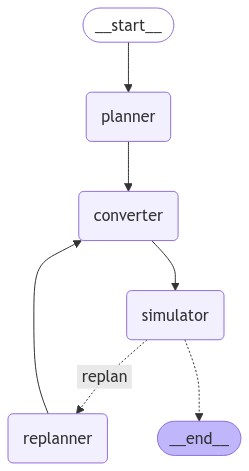

In [8]:
async def plan_step(state: PlanSimulateState):
    checksum_from_address = convert_to_checksum_address.invoke(
        {"address": state["from_address"]}
    )
    plan = await planner.ainvoke(state["input"])
    steps = [step.description for step in plan.steps]
    return {"from_address": checksum_from_address, "steps": steps}


async def convert_step(state: PlanSimulateState):
    step = state["steps"][0]
    tx_params = await generate_tx_params(step, state["from_address"])
    return {"current_step": (step, tx_params)}


async def simulate_step(state: PlanSimulateState):
    step, tx_params = state["current_step"]
    simulated_txs = [tx for _, tx, _ in state["simulated_txs"]]
    txs = simulated_txs + [tx_params]

    result = await simulate_transaction.ainvoke({"transactions": txs})
    # Get the result of the last transaction
    last_tx_result = result.tx_results[-1]
    # If the last transaction is successful, add it to the list of simulated transactions
    if not last_tx_result.error:
        return {
            "simulated_txs": [(step, tx_params, last_tx_result.asset_changes)],
            # Remove the current step if the simulation is successful
            "steps": state["steps"][1:],
            "error": None,
        }
    else:
        return {"error": last_tx_result.error}


def should_replan(state: PlanSimulateState) -> Literal["replan", "__end__"]:
    steps = state.get("steps")
    # error = state.get("error")
    # if error:
    #     # If there is an error, convert the transaction again
    #     print(f"Error: {error}")
    #     return "convert"
    if steps:
        # If there are steps, continue the workflow
        return "replan"
    else:
        return "__end__"


from langgraph.graph import StateGraph, END

workflow = StateGraph(PlanSimulateState)
# Add nodes
workflow.add_node("planner", plan_step)
workflow.add_node("converter", convert_step)
workflow.add_node("simulator", simulate_step)
workflow.add_node("replanner", replan_step)

# Add edges
workflow.set_entry_point("planner")
workflow.add_edge("planner", "converter")
workflow.add_edge("converter", "simulator")
workflow.add_edge("replanner", "converter")
workflow.add_conditional_edges(
    "simulator", should_replan, {"replan": "replanner", "__end__": END}
)
# Create graph
app = workflow.compile()

display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [9]:
def print_result(result):
    print(f"Original Intent: {result['input']}")
    print("-" * 100)
    txs = result["simulated_txs"]
    for index, (desc, tx_params, asset_changes) in enumerate(txs, 1):
        normalized_from_address = tx_params.from_address.lower()
        print(f"{index}. {desc}")
        print("Transaction Parameters:")
        print(f"  From:  {tx_params.from_address}")
        print(f"  To:    {tx_params.to_address}")
        print(f"  Data:  {tx_params.data}")
        print(f"  Value: {tx_params.value}")

        if asset_changes:
            print("Transaction Summary:")
            _print_asset_changes(asset_changes, normalized_from_address)

        print("-" * 100)


def _print_asset_changes(asset_changes, from_address):
    from graph.replanner import convert_hex_amount_to_decimal

    for asset_change in asset_changes:
        dir = _get_direction(asset_change.sender, asset_change.receiver, from_address)
        amount = convert_hex_amount_to_decimal(
            asset_change.raw_amount, asset_change.decimals
        )
        print(f"  {dir}{amount} {asset_change.symbol}")


def _get_direction(asset_sender: str, asset_receiver: str, from_address: str) -> str:
    if asset_sender.lower() == from_address:
        return "-"
    elif asset_receiver.lower() == from_address:
        return "+"
    raise ValueError("Asset sender and receiver cannot be the same")

In [10]:
from_address = "0xd8da6bf26964af9d7eed9e03e53415d37aa96045"
input = {"from_address": from_address, "input": "Swap 0.05 USDC to USDT"}

result = {}
async for type, chunk in app.astream(input, stream_mode=["values", "updates"]):
    print(f"Type: {type}")
    if type == "values":
        result = chunk
        print(f"Graph: {chunk}")
        print("-" * 100)
    elif type == "updates":
        for node, values in chunk.items():
            print(f"Node: {node}")
            print(values)
            print("-" * 100)

print_result(result)

Type: values
Graph: {'from_address': '0xd8da6bf26964af9d7eed9e03e53415d37aa96045', 'input': 'Swap 100 USDC to USDT', 'simulated_txs': []}
----------------------------------------------------------------------------------------------------
Type: updates
Node: planner
{'from_address': '0xd8dA6BF26964aF9D7eEd9e03E53415D37aA96045', 'steps': ['Approve USDC for Uniswap.', 'Swap 100 USDC to USDT on Uniswap.']}
----------------------------------------------------------------------------------------------------
Type: values
Graph: {'from_address': '0xd8dA6BF26964aF9D7eEd9e03E53415D37aA96045', 'input': 'Swap 100 USDC to USDT', 'steps': ['Approve USDC for Uniswap.', 'Swap 100 USDC to USDT on Uniswap.'], 'simulated_txs': []}
----------------------------------------------------------------------------------------------------
Type: updates
Node: converter
{'current_step': ('Approve USDC for Uniswap.', TransactionParams(from_address='0xd8dA6BF26964aF9D7eEd9e03E53415D37aA96045', to_address='0xa0b86991

GraphRecursionError: Recursion limit of 25 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.

In [ ]:
input = {
    "from_address": "0xd8da6bf26964af9d7eed9e03e53415d37aa96045",
    "input": "Stake 0.03 ETH with Lido and deposit to Eigenpie",
}
async for type, chunk in app.astream(
    input, interrupt_before=["converter"], stream_mode=["values", "updates"]
):
    print(f"Type: {type}")
    if type == "values":
        print(f"Graph: {chunk}")
        print("-" * 100)
    elif type == "updates":
        for node, values in chunk.items():
            print(f"Node: {node}")
            print(values)
            print("-" * 100)